In [ ]:



import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import cv2
from PIL import Image
import os
from tqdm import tqdm
import random
from collections import defaultdict
import pandas as pd
import warnings
import timm
import torch
import torch.nn as nn
import torch.optim as optim

warnings.filterwarnings('ignore')


torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:






def prepare_cifar10():
    """Prepare CIFAR-10 dataset with standard transforms"""
    transform_train = transforms.Compose([
        transforms.Resize(224),  
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

    return trainloader, testloader, testset


cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


train_loader, test_loader, test_dataset = prepare_cifar10()
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


def load_model_resnet():

    
    resnet = torchvision.models.resnet50(pretrained=True)
    resnet.fc = nn.Linear(resnet.fc.in_features, 10)  

    return resnet


resnet_model = load_model_resnet()
resnet_model = resnet_model.to(device)


vit_model = timm.create_model(
    'vit_small_patch16_224',   
    pretrained=True,
    num_classes=10             
).to(device)



100%|██████████| 170M/170M [00:14<00:00, 11.5MB/s]


Training samples: 50000
Test samples: 10000
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [ ]:





def train_model(model, train_loader, test_loader, model_name, epochs=10):
    """Train model and return training history"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, train_accs, val_accs = [], [], []

    for epoch in range(epochs):
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f'{model_name} Epoch {epoch+1}')):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)

        
        val_acc = evaluate_model(model, test_loader, verbose=False)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Loss: {train_loss:.4f}')

    return train_losses, train_accs, val_accs

def train_vit(model, train_loader, test_loader, model_name="ViT-S/16", epochs=50):
    """Specialized training loop for ViT with tqdm"""
    criterion = nn.CrossEntropyLoss()
    
    
    optimizer = optim.Adam(model.parameters(), lr=5e-4)


    train_losses, train_accs, val_accs = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        
        loop = tqdm(train_loader, desc=f"[{model_name}] Epoch {epoch+1}/{epochs}")
        for inputs, targets in loop:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            
            loop.set_postfix(loss=loss.item())

        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)

        
        val_acc = evaluate_model(model, test_loader, verbose=False)

        
        

        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"[{model_name}] Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Loss: {train_loss:.4f}")

    return train_losses, train_accs, val_accs


def evaluate_model(model, dataloader, verbose=True):
    """Evaluate model accuracy"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    if verbose:
        print(f'Accuracy: {accuracy:.2f}%')
    return accuracy



In [ ]:

print("Training ResNet-50...")
resnet_history = train_model(resnet_model, train_loader, test_loader, "ResNet-50", epochs=5)

Training ResNet-50...


ResNet-50 Epoch 1: 100%|██████████| 782/782 [08:53<00:00,  1.47it/s]


Epoch 1: Train Acc: 73.20%, Val Acc: 70.05%, Loss: 0.7707


ResNet-50 Epoch 2: 100%|██████████| 782/782 [08:50<00:00,  1.47it/s]


Epoch 2: Train Acc: 84.35%, Val Acc: 79.51%, Loss: 0.4581


ResNet-50 Epoch 3: 100%|██████████| 782/782 [08:51<00:00,  1.47it/s]


Epoch 3: Train Acc: 87.59%, Val Acc: 84.97%, Loss: 0.3640


ResNet-50 Epoch 4: 100%|██████████| 782/782 [08:49<00:00,  1.48it/s]


Epoch 4: Train Acc: 89.52%, Val Acc: 86.95%, Loss: 0.3048


ResNet-50 Epoch 5: 100%|██████████| 782/782 [08:50<00:00,  1.48it/s]


Epoch 5: Train Acc: 91.01%, Val Acc: 89.11%, Loss: 0.2588


In [ ]:
torch.save(resnet_model.state_dict(), "resnet50_task1.pth")

In [ ]:




print("\nTraining ViT-S/16...")
vit_history = train_vit(vit_model, train_loader, test_loader, "ViT-S/16", epochs=3)


Training ViT-S/16...


[ViT-S/16] Epoch 1/3: 100%|██████████| 782/782 [08:44<00:00,  1.49it/s, loss=0.509]


[ViT-S/16] Epoch 1/3 | Train Acc: 81.97% | Val Acc: 84.73% | Loss: 0.5240


[ViT-S/16] Epoch 2/3: 100%|██████████| 782/782 [08:42<00:00,  1.50it/s, loss=0.392] 


[ViT-S/16] Epoch 2/3 | Train Acc: 89.40% | Val Acc: 89.67% | Loss: 0.3138


[ViT-S/16] Epoch 3/3: 100%|██████████| 782/782 [08:42<00:00,  1.50it/s, loss=0.0965]


[ViT-S/16] Epoch 3/3 | Train Acc: 90.95% | Val Acc: 90.28% | Loss: 0.2657


In [ ]:
resnet_history

([0.7706684034956081,
  0.4581351485055731,
  0.36395373768018335,
  0.30483414715780016,
  0.25883708267336913],
 [73.196, 84.346, 87.594, 89.516, 91.008],
 [70.05, 79.51, 84.97, 86.95, 89.11])

In [ ]:
vit_history

([0.5240181892767282, 0.31384455214452256, 0.26567397370953544],
 [81.972, 89.398, 90.952],
 [84.73, 89.67, 90.28])

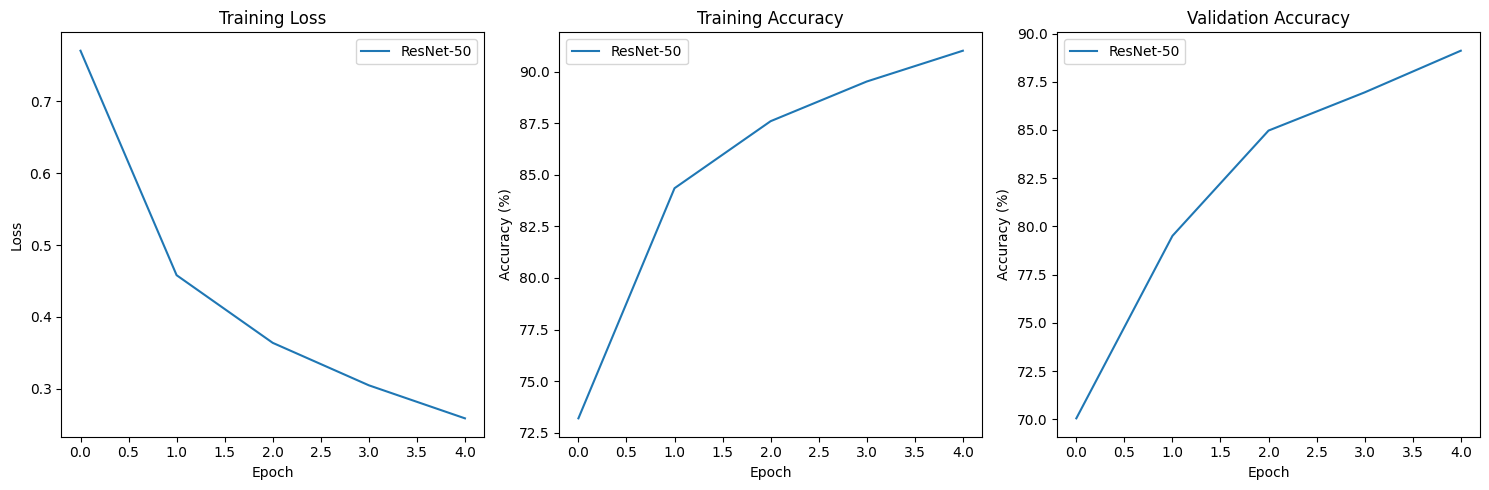

In [ ]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(resnet_history[0], label='ResNet-50')

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(resnet_history[1], label='ResNet-50')

plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(resnet_history[2], label='ResNet-50')

plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


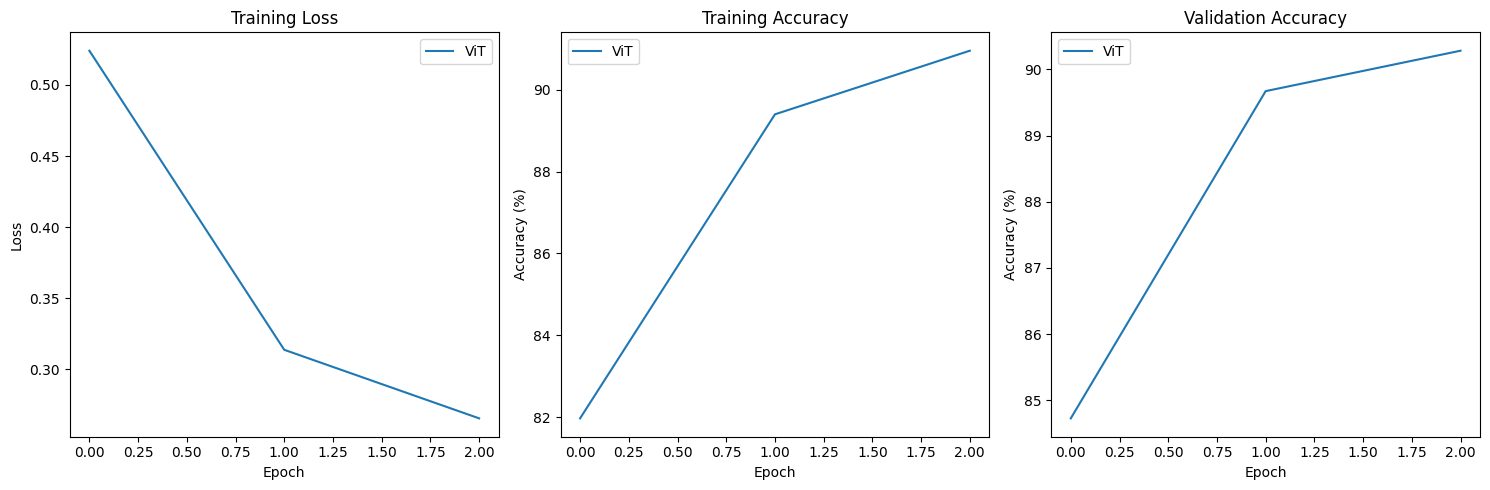

In [ ]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)

plt.plot(vit_history[0], label='ViT')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)

plt.plot(vit_history[1], label='ViT')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)

plt.plot(vit_history[2], label='ViT')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

torch.save(vit_model.state_dict(), "vit_task1.pth")

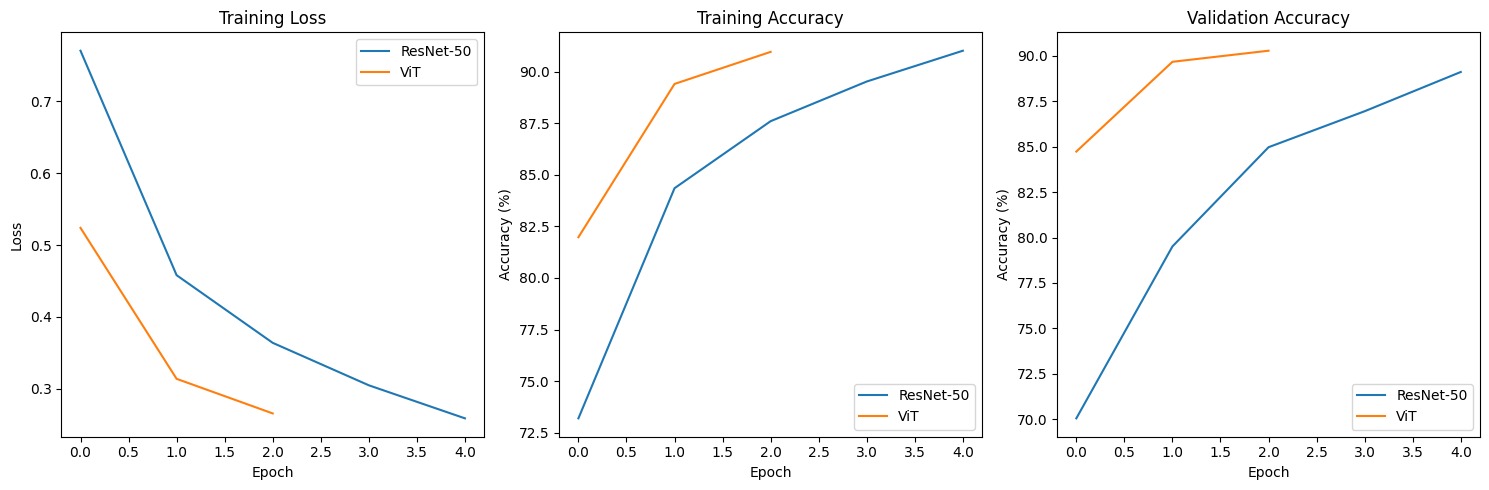

In [ ]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(resnet_history[0], label='ResNet-50')
plt.plot(vit_history[0], label='ViT')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(resnet_history[1], label='ResNet-50')
plt.plot(vit_history[1], label='ViT')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(resnet_history[2], label='ResNet-50')
plt.plot(vit_history[2], label='ViT')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:





print("=== IN-DISTRIBUTION PERFORMANCE ===")
print("ResNet-50 Test Accuracy:")
resnet_baseline_acc = evaluate_model(resnet_model, test_loader)
print("ViT Test Accuracy:")
vit_baseline_acc = evaluate_model(vit_model, test_loader)


=== IN-DISTRIBUTION PERFORMANCE ===
ResNet-50 Test Accuracy:
Accuracy: 89.11%
ViT Test Accuracy:
Accuracy: 90.28%


RELOAD

In [5]:
!unzip /content/model_weights_atml.zip -d /content/

Archive:  /content/model_weights_atml.zip
  inflating: /content/resnet50_task1.pth  
  inflating: /content/vit_task1.pth  


In [ ]:

resnet_model.load_state_dict(torch.load("/content/resnet50_task1.pth", map_location=device))


print("Evaluating ResNet-50 from checkpoint...")
evaluate_model(resnet_model, test_loader)

Evaluating ResNet-50 from checkpoint...
Accuracy: 89.11%


89.11

In [ ]:
vit_model = timm.create_model(
    'vit_small_patch16_224',
    pretrained=False,
    num_classes=10
).to(device)


vit_model.load_state_dict(torch.load("/content/vit_task1.pth", map_location=device))


print("Evaluating ViT-S/16 from checkpoint...")
evaluate_model(vit_model, test_loader)

Evaluating ViT-S/16 from checkpoint...
Accuracy: 90.28%


90.28

---

=== COLOR BIAS TEST ===
ResNet-50 Grayscale Accuracy:
Accuracy: 15.80%
ViT Grayscale Accuracy:
Accuracy: 35.90%

Color Bias Analysis:
ResNet-50 accuracy drop: 73.31%
ViT accuracy drop: 54.38%


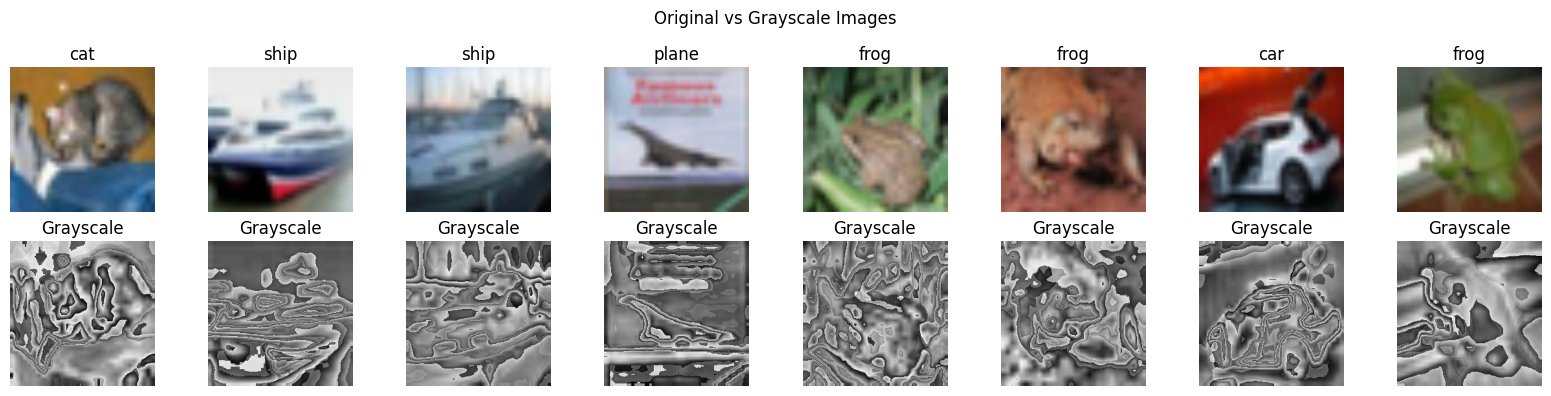

In [ ]:





def create_grayscale_dataset(dataset):
    """Convert dataset to grayscale"""
    class GrayscaleDataset(Dataset):
        def __init__(self, original_dataset):
            self.dataset = original_dataset

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            image, label = self.dataset[idx]
            
            gray = transforms.Grayscale(num_output_channels=3)(
                transforms.ToPILImage()(image)
            )
            gray_tensor = transforms.ToTensor()(gray)
            
            gray_tensor = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(gray_tensor)
            return gray_tensor, label

    return GrayscaleDataset(dataset)

print("=== COLOR BIAS TEST ===")
grayscale_dataset = create_grayscale_dataset(test_dataset)
grayscale_loader = DataLoader(grayscale_dataset, batch_size=64, shuffle=False)

print("ResNet-50 Grayscale Accuracy:")
resnet_gray_acc = evaluate_model(resnet_model, grayscale_loader)
print("ViT Grayscale Accuracy:")
vit_gray_acc = evaluate_model(vit_model, grayscale_loader)


resnet_color_bias = resnet_baseline_acc - resnet_gray_acc
vit_color_bias = vit_baseline_acc - vit_gray_acc

print(f"\nColor Bias Analysis:")
print(f"ResNet-50 accuracy drop: {resnet_color_bias:.2f}%")
print(f"ViT accuracy drop: {vit_color_bias:.2f}%")


def visualize_grayscale_samples(dataset, n_samples=8):
    """Visualize original vs grayscale images"""
    fig, axes = plt.subplots(2, n_samples, figsize=(16, 4))

    for i in range(n_samples):
        
        orig_img, label = test_dataset[i]
        orig_img_display = torch.clamp(orig_img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) +
                                      torch.tensor([0.485, 0.456, 0.406]).view(3,1,1), 0, 1)
        axes[0, i].imshow(orig_img_display.permute(1, 2, 0))
        axes[0, i].set_title(f'{cifar10_classes[label]}')
        axes[0, i].axis('off')

        
        gray_img, _ = grayscale_dataset[i]
        gray_img_display = torch.clamp(gray_img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) +
                                      torch.tensor([0.485, 0.456, 0.406]).view(3,1,1), 0, 1)
        axes[1, i].imshow(gray_img_display.permute(1, 2, 0))
        axes[1, i].set_title('Grayscale')
        axes[1, i].axis('off')

    plt.suptitle('Original vs Grayscale Images')
    plt.tight_layout()
    plt.show()

visualize_grayscale_samples(test_dataset)


=== ENHANCED SHAPE VS TEXTURE BIAS TEST ===
ResNet-50 Enhanced Shape Bias:
Shape bias: 36.00%
ViT Enhanced Shape Bias:
Shape bias: 60.60%


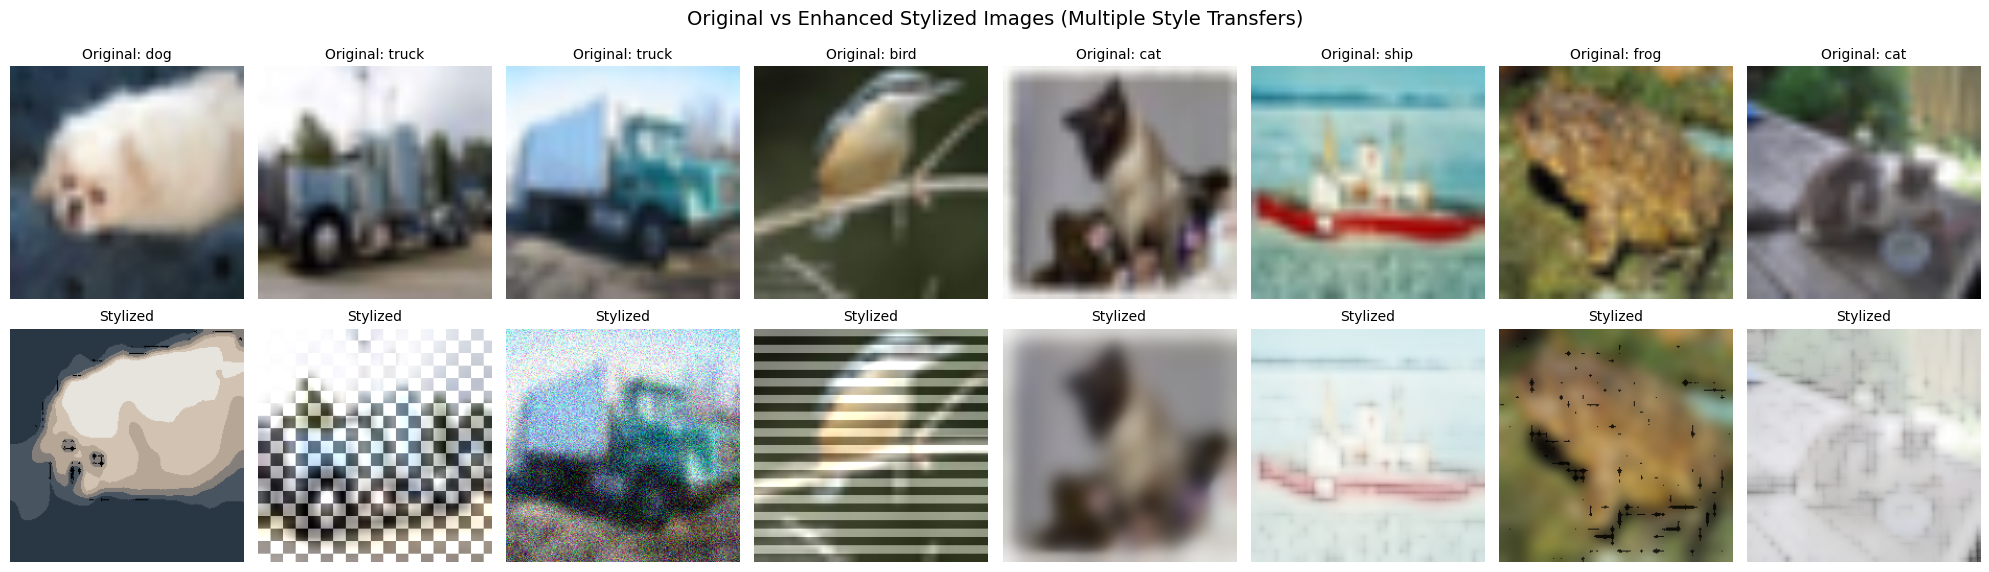

In [ ]:




def create_stylized_dataset(dataset, n_samples=1000):
    """Create stylized images using advanced texture modifications including cartoon style transfer"""
    class StylizedDataset(Dataset):
        def __init__(self, original_dataset, n_samples):
            self.dataset = original_dataset
            self.indices = random.sample(range(len(original_dataset)), min(n_samples, len(original_dataset)))

        def __len__(self):
            return len(self.indices)

        def apply_texture_transfer(self, image):
            """Advanced texture modification with multiple stylization techniques"""
            img_np = image.permute(1, 2, 0).numpy()

            
            patterns = [
                self.add_checkerboard_pattern,
                self.add_stripe_pattern,
                self.add_noise_pattern,
                self.apply_cartoon_style,
                self.apply_oil_painting_style,
                self.apply_watercolor_style,
                self.apply_sketch_style,
                self.apply_mosaic_style
            ]

            pattern_func = random.choice(patterns)
            stylized = pattern_func(img_np)

            return torch.from_numpy(stylized).permute(2, 0, 1).float()

        def add_checkerboard_pattern(self, img, size=12):
            """Add checkerboard pattern with higher intensity"""
            h, w, c = img.shape
            pattern = np.zeros((h, w))
            for i in range(0, h, size):
                for j in range(0, w, size):
                    if (i//size + j//size) % 2 == 0:
                        pattern[i:i+size, j:j+size] = 0.5

            stylized = img.copy()
            for ch in range(c):
                stylized[:,:,ch] = np.clip(stylized[:,:,ch] + pattern, 0, 1)
            return stylized

        def add_stripe_pattern(self, img, width=8):
            """Add stripe pattern with higher intensity"""
            h, w, c = img.shape
            pattern = np.zeros((h, w))
            for i in range(0, h, width*2):
                pattern[i:i+width, :] = 0.4

            stylized = img.copy()
            for ch in range(c):
                stylized[:,:,ch] = np.clip(stylized[:,:,ch] + pattern, 0, 1)
            return stylized

        def add_noise_pattern(self, img):
            """Add more pronounced noise pattern"""
            noise = np.random.normal(0, 0.15, img.shape)
            return np.clip(img + noise, 0, 1)

        def apply_cartoon_style(self, img):
            """Apply cartoon/anime style effect with color quantization"""
            img_uint8 = (img * 255).astype(np.uint8)

            
            smooth = cv2.bilateralFilter(img_uint8, 15, 60, 60)

            
            h, w, c = smooth.shape
            data = smooth.reshape((-1, 3))
            data = np.float32(data)

            
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 8, 1.0)
            k = 6  
            _, labels, centers = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

            
            centers = np.uint8(centers)
            quantized = centers[labels.flatten()]
            quantized = quantized.reshape(smooth.shape)

            
            gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
            gray_blur = cv2.medianBlur(gray, 3)
            edges = cv2.adaptiveThreshold(gray_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                        cv2.THRESH_BINARY, 5, 5)

            
            edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
            edges = edges / 255.0
            quantized = quantized / 255.0

            
            cartoon = quantized * edges

            return np.clip(cartoon, 0, 1)

        def apply_oil_painting_style(self, img):
            """Apply oil painting effect"""
            img_uint8 = (img * 255).astype(np.uint8)

            
            oil1 = cv2.bilateralFilter(img_uint8, 20, 200, 200)
            oil2 = cv2.bilateralFilter(oil1, 20, 200, 200)
            oil3 = cv2.bilateralFilter(oil2, 15, 150, 150)

            return (oil3.astype(np.float32) / 255.0)

        def apply_watercolor_style(self, img):
            """Apply watercolor effect"""
            img_uint8 = (img * 255).astype(np.uint8)

            
            
            blurred1 = cv2.GaussianBlur(img_uint8, (21, 21), 0)
            blurred2 = cv2.GaussianBlur(blurred1, (21, 21), 0)

            
            gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
            edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                        cv2.THRESH_BINARY, 9, 9)

            
            edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
            edges = edges / 255.0
            blurred2 = blurred2 / 255.0

            
            watercolor = blurred2 * edges * 0.8 + blurred2 * 0.2

            return np.clip(watercolor, 0, 1)

        def apply_sketch_style(self, img):
            """Apply pencil sketch effect"""
            img_uint8 = (img * 255).astype(np.uint8)

            
            gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)

            
            gray_inv = 255 - gray
            blur_inv = cv2.GaussianBlur(gray_inv, (21, 21), 0)
            sketch_gray = cv2.divide(gray, 255 - blur_inv, scale=256)

            
            sketch = cv2.cvtColor(sketch_gray, cv2.COLOR_GRAY2RGB)

            
            sketch = sketch.astype(np.float32) / 255.0
            color_tint = img * 0.3 + sketch * 0.7

            return np.clip(color_tint, 0, 1)

        def apply_mosaic_style(self, img, tile_size=8):
            """Apply mosaic/pixelated effect"""
            img_uint8 = (img * 255).astype(np.uint8)
            h, w, c = img_uint8.shape

            
            mosaic = img_uint8.copy()

            for i in range(0, h - tile_size, tile_size):
                for j in range(0, w - tile_size, tile_size):
                    
                    block = img_uint8[i:i+tile_size, j:j+tile_size]

                    
                    avg_color = np.mean(block, axis=(0, 1))

                    
                    mosaic[i:i+tile_size, j:j+tile_size] = avg_color

            return mosaic.astype(np.float32) / 255.0

        def __getitem__(self, idx):
            original_idx = self.indices[idx]
            image, label = self.dataset[original_idx]

            
            image_denorm = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + \
                          torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            image_denorm = torch.clamp(image_denorm, 0, 1)

            
            stylized_image = self.apply_texture_transfer(image_denorm)

            
            stylized_image = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(stylized_image)

            return stylized_image, label, original_idx

    return StylizedDataset(dataset, n_samples)

print("=== ENHANCED SHAPE VS TEXTURE BIAS TEST ===")
stylized_dataset = create_stylized_dataset(test_dataset, n_samples=500)
stylized_loader = DataLoader(stylized_dataset, batch_size=64, shuffle=False)

def evaluate_shape_bias(model, stylized_loader, original_dataset):
    """
    Evaluate shape vs texture bias using cue-conflict dataset.

    This function tests models on images where texture has been dramatically altered
    while preserving the overall shape/structure. The stylized images create cue conflicts:
    - SHAPE information remains (object contours, edges, spatial arrangement)
    - TEXTURE information is replaced (colors, surface patterns, artistic styles)

    A shape-biased model should classify based on preserved object structure,
    while a texture-biased model may be confused by the altered surface appearance.
    """
    model.eval()
    shape_correct = 0
    texture_confused = 0
    total = 0

    predictions = []
    original_labels = []

    with torch.no_grad():
        for stylized_imgs, labels, orig_indices in stylized_loader:
            stylized_imgs = stylized_imgs.to(device)
            outputs = model(stylized_imgs)
            _, predicted = outputs.max(1)

            for i in range(len(predicted)):
                pred = predicted[i].cpu().item()
                true_label = labels[i].item()

                predictions.append(pred)
                original_labels.append(true_label)

                if pred == true_label:
                    shape_correct += 1
                else:
                    texture_confused += 1
                total += 1

    shape_bias = (shape_correct / total) * 100 if total > 0 else 0

    return shape_bias, predictions, original_labels

print("ResNet-50 Enhanced Shape Bias:")
resnet_shape_bias, resnet_preds, orig_labels = evaluate_shape_bias(resnet_model, stylized_loader, test_dataset)
print(f"Shape bias: {resnet_shape_bias:.2f}%")

print("ViT Enhanced Shape Bias:")
vit_shape_bias, vit_preds, _ = evaluate_shape_bias(vit_model, stylized_loader, test_dataset)
print(f"Shape bias: {vit_shape_bias:.2f}%")


def visualize_enhanced_stylized_examples(dataset, n_examples=8):
    """Visualize enhanced stylized examples with style identification"""
    fig, axes = plt.subplots(2, n_examples, figsize=(20, 6))

    
    style_names = ['Checkerboard', 'Stripes', 'Noise', 'Cartoon', 'Oil Painting',
                   'Watercolor', 'Sketch', 'Mosaic']

    for i in range(n_examples):
        
        orig_idx = dataset.indices[i]
        orig_img, label = test_dataset[orig_idx]
        orig_img_display = torch.clamp(orig_img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) +
                                      torch.tensor([0.485, 0.456, 0.406]).view(3,1,1), 0, 1)
        axes[0, i].imshow(orig_img_display.permute(1, 2, 0))
        axes[0, i].set_title(f'Original: {cifar10_classes[label]}', fontsize=10)
        axes[0, i].axis('off')

        
        stylized_img, _, _ = dataset[i]
        stylized_img_display = torch.clamp(stylized_img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) +
                                          torch.tensor([0.485, 0.456, 0.406]).view(3,1,1), 0, 1)
        axes[1, i].imshow(stylized_img_display.permute(1, 2, 0))

        
        style_name = "Stylized"  
        axes[1, i].set_title(f'{style_name}', fontsize=10)
        axes[1, i].axis('off')

    plt.suptitle('Original vs Enhanced Stylized Images (Multiple Style Transfers)', fontsize=14)
    plt.tight_layout()
    plt.show()




visualize_enhanced_stylized_examples(stylized_dataset)

In [ ]:





def create_translated_dataset(dataset, shift_pixels=5, n_samples=1000):
    """Create dataset with translated images"""
    class TranslatedDataset(Dataset):
        def __init__(self, original_dataset, shift_pixels, n_samples):
            self.dataset = original_dataset
            self.shift_pixels = shift_pixels
            self.indices = random.sample(range(len(original_dataset)), min(n_samples, len(original_dataset)))

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            original_idx = self.indices[idx]
            image, label = self.dataset[original_idx]

            
            image_denorm = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + \
                          torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            image_denorm = torch.clamp(image_denorm, 0, 1)

            
            img_np = image_denorm.permute(1, 2, 0).numpy()
            h, w, c = img_np.shape

            
            dx = random.randint(-self.shift_pixels, self.shift_pixels)
            dy = random.randint(-self.shift_pixels, self.shift_pixels)

            
            M = np.float32([[1, 0, dx], [0, 1, dy]])
            translated = cv2.warpAffine(img_np, M, (w, h), borderMode=cv2.BORDER_REFLECT)

            
            translated_tensor = torch.from_numpy(translated).permute(2, 0, 1).float()
            translated_tensor = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(translated_tensor)

            return translated_tensor, label, original_idx, (dx, dy)

    return TranslatedDataset(dataset, shift_pixels, n_samples)

print("=== TRANSLATION INVARIANCE TEST ===")
translated_dataset = create_translated_dataset(test_dataset, shift_pixels=64, n_samples=500)
translated_loader = DataLoader(translated_dataset, batch_size=64, shuffle=False)

def evaluate_translation_invariance(model, translated_loader, original_dataset):
    """Evaluate translation invariance"""
    model.eval()
    consistent_predictions = 0
    total = 0
    accuracy = 0

    with torch.no_grad():
        for translated_imgs, labels, orig_indices, shifts in translated_loader:
            translated_imgs = translated_imgs.to(device)

            
            outputs = model(translated_imgs)
            _, translated_preds = outputs.max(1)

            
            orig_batch = []
            for idx in orig_indices:
                orig_img, _ = original_dataset[idx]
                orig_batch.append(orig_img.unsqueeze(0))

            orig_batch = torch.cat(orig_batch).to(device)
            orig_outputs = model(orig_batch)
            _, orig_preds = orig_outputs.max(1)

            
            for i in range(len(translated_preds)):
                if translated_preds[i] == orig_preds[i]:
                    consistent_predictions += 1
                if translated_preds[i] == labels[i]:
                    accuracy += 1
                total += 1

    consistency = (consistent_predictions / total) * 100 if total > 0 else 0
    accuracy = (accuracy / total) * 100 if total > 0 else 0

    return consistency, accuracy

print("ResNet-50 Translation Invariance:")
resnet_consistency, resnet_trans_acc = evaluate_translation_invariance(resnet_model, translated_loader, test_dataset)
print(f"Consistency: {resnet_consistency:.2f}%, Accuracy: {resnet_trans_acc:.2f}%")

print("ViT Translation Invariance:")
vit_consistency, vit_trans_acc = evaluate_translation_invariance(vit_model, translated_loader, test_dataset)
print(f"Consistency: {vit_consistency:.2f}%, Accuracy: {vit_trans_acc:.2f}%")


=== TRANSLATION INVARIANCE TEST ===
ResNet-50 Translation Invariance:
Consistency: 83.40%, Accuracy: 79.00%
ViT Translation Invariance:
Consistency: 82.00%, Accuracy: 80.60%


=== ENHANCED TRANSLATION INVARIANCE ANALYSIS ===
=== COMPREHENSIVE TRANSLATION INVARIANCE TEST ===
Testing shift levels: [3, 5, 8, 16, 32]
Samples per test: 600

Generating visualization of translations...


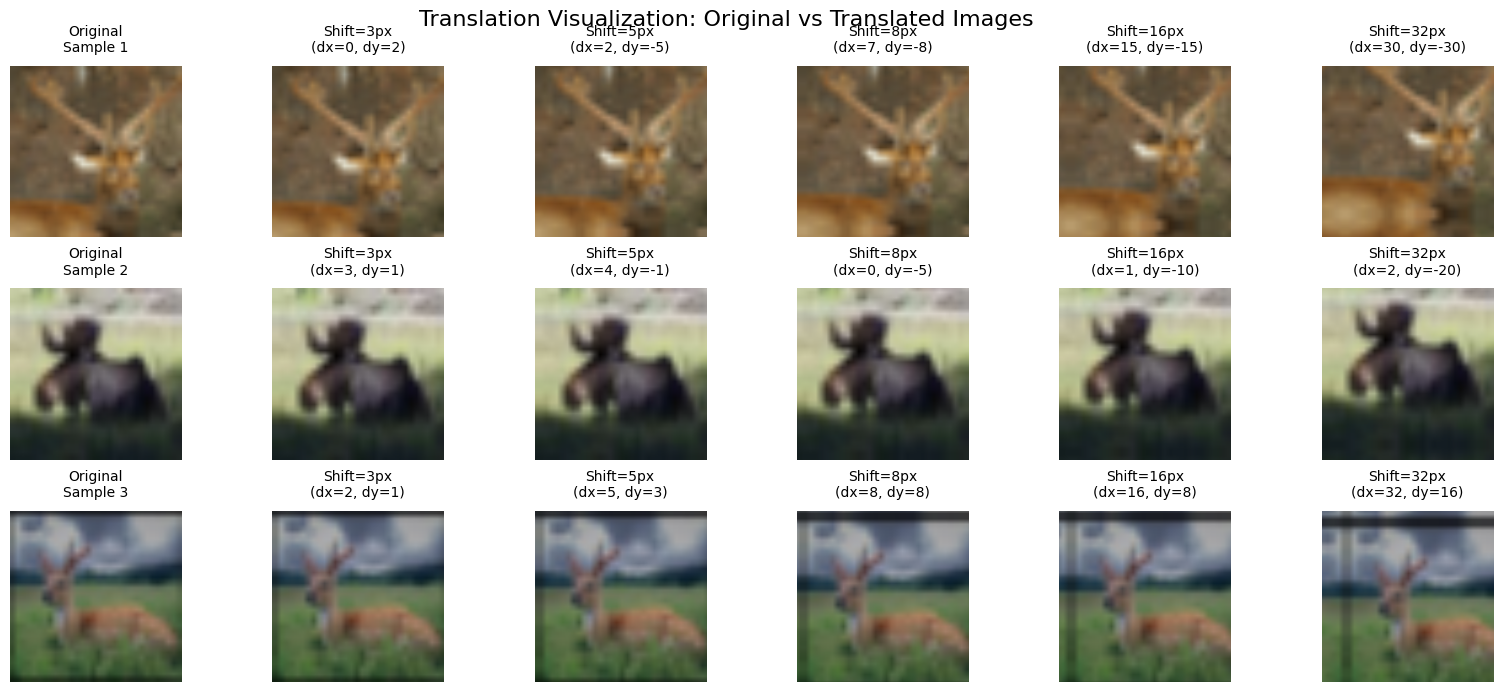


-------------------- ResNet-50 --------------------

Testing shift = 3px...
  Consistency: 98.00% | Accuracy: 88.33%

Testing shift = 5px...
  Consistency: 96.33% | Accuracy: 91.17%

Testing shift = 8px...
  Consistency: 95.83% | Accuracy: 88.67%

Testing shift = 16px...
  Consistency: 94.67% | Accuracy: 88.50%

Testing shift = 32px...
  Consistency: 92.17% | Accuracy: 84.00%

-------------------- ViT --------------------

Testing shift = 3px...
  Consistency: 96.83% | Accuracy: 90.17%

Testing shift = 5px...
  Consistency: 95.00% | Accuracy: 90.33%

Testing shift = 8px...
  Consistency: 92.00% | Accuracy: 88.50%

Testing shift = 16px...
  Consistency: 93.00% | Accuracy: 88.67%

Testing shift = 32px...
  Consistency: 91.67% | Accuracy: 87.67%


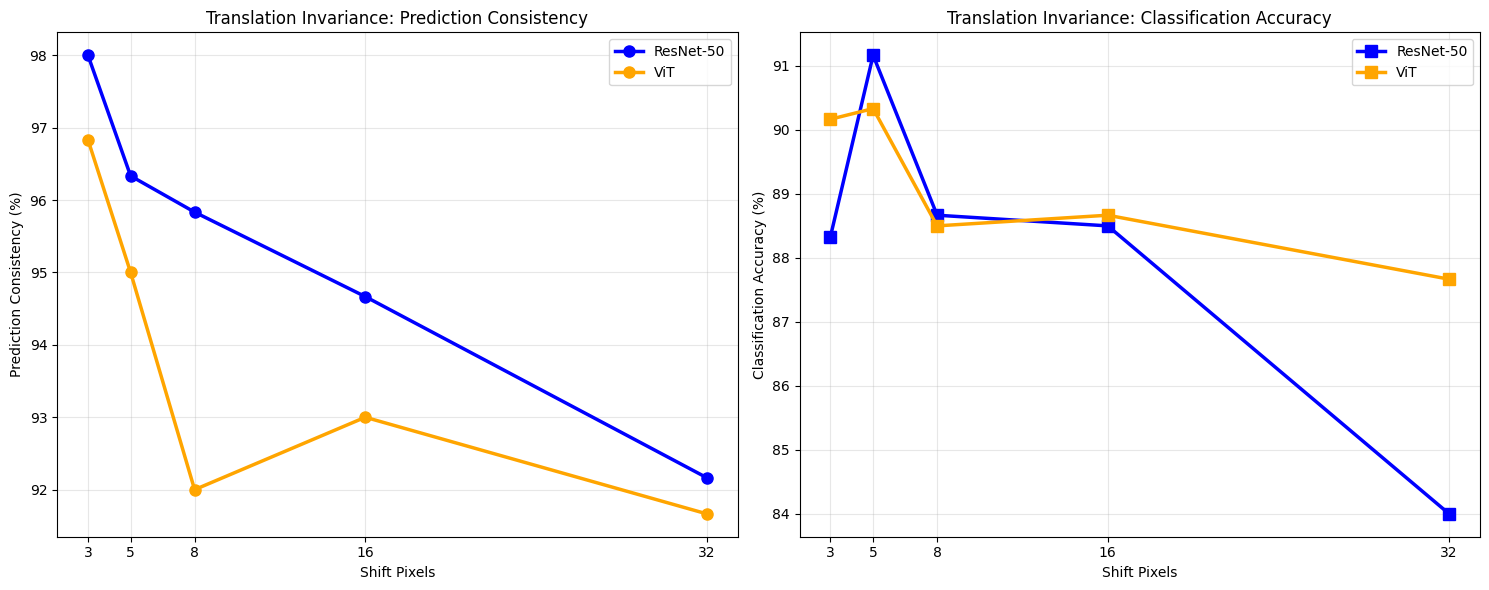


SUMMARY TABLE
Shift    Model        Consistency  Accuracy    
--------------------------------------------------------------------------------
3        ResNet-50    98.00      % 88.33      %
3        ViT          96.83      % 90.17      %
5        ResNet-50    96.33      % 91.17      %
5        ViT          95.00      % 90.33      %
8        ResNet-50    95.83      % 88.67      %
8        ViT          92.00      % 88.50      %
16       ResNet-50    94.67      % 88.50      %
16       ViT          93.00      % 88.67      %
32       ResNet-50    92.17      % 84.00      %
32       ViT          91.67      % 87.67      %


In [ ]:




import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import numpy as np
import torch

def create_translated_dataset(dataset, shift_pixels=5, n_samples=1000):
    """Create dataset with translated images"""
    class TranslatedDataset(Dataset):
        def __init__(self, original_dataset, shift_pixels, n_samples):
            self.dataset = original_dataset
            self.shift_pixels = shift_pixels
            self.indices = random.sample(range(len(original_dataset)), min(n_samples, len(original_dataset)))

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            original_idx = self.indices[idx]
            image, label = self.dataset[original_idx]

            
            image_denorm = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + \
                          torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            image_denorm = torch.clamp(image_denorm, 0, 1)

            
            img_np = image_denorm.permute(1, 2, 0).numpy()
            h, w, c = img_np.shape

            
            dx = random.randint(-self.shift_pixels, self.shift_pixels)
            dy = random.randint(-self.shift_pixels, self.shift_pixels)

            
            M = np.float32([[1, 0, dx], [0, 1, dy]])
            translated = cv2.warpAffine(img_np, M, (w, h), borderMode=cv2.BORDER_REFLECT)

            
            translated_tensor = torch.from_numpy(translated).permute(2, 0, 1).float()
            translated_tensor = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(translated_tensor)

            return translated_tensor, label, original_idx, (dx, dy)

    return TranslatedDataset(dataset, shift_pixels, n_samples)

def evaluate_translation_invariance(model, translated_loader, original_dataset):
    """Evaluate translation invariance"""
    model.eval()
    consistent_predictions = 0
    total = 0
    accuracy = 0

    with torch.no_grad():
        for translated_imgs, labels, orig_indices, shifts in translated_loader:
            translated_imgs = translated_imgs.to(device)

            
            outputs = model(translated_imgs)
            _, translated_preds = outputs.max(1)

            
            orig_batch = []
            for idx in orig_indices:
                orig_img, _ = original_dataset[idx]
                orig_batch.append(orig_img.unsqueeze(0))

            orig_batch = torch.cat(orig_batch).to(device)
            orig_outputs = model(orig_batch)
            _, orig_preds = orig_outputs.max(1)

            
            for i in range(len(translated_preds)):
                if translated_preds[i] == orig_preds[i]:
                    consistent_predictions += 1
                if translated_preds[i] == labels[i]:
                    accuracy += 1
                total += 1

    consistency = (consistent_predictions / total) * 100 if total > 0 else 0
    accuracy = (accuracy / total) * 100 if total > 0 else 0

    return consistency, accuracy

def visualize_translations(original_dataset, shift_levels, n_samples=3):
    """Visualize original vs translated images at different shift levels"""
    plt.figure(figsize=(20, 8))
    gs = GridSpec(n_samples, len(shift_levels) + 1, hspace=0.3, wspace=0.1)

    
    sample_indices = random.sample(range(len(original_dataset)), n_samples)

    for row, sample_idx in enumerate(sample_indices):
        
        orig_img, orig_label = original_dataset[sample_idx]
        orig_img_np = orig_img.permute(1, 2, 0).numpy()
        orig_img_np = orig_img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        orig_img_np = np.clip(orig_img_np, 0, 1)

        ax = plt.subplot(gs[row, 0])
        ax.imshow(orig_img_np)
        ax.set_title(f'Original\nSample {row+1}', fontsize=10, pad=10)
        ax.axis('off')

        
        for col, shift_pixels in enumerate(shift_levels):
            
            img_denorm = orig_img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + \
                        torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            img_denorm = torch.clamp(img_denorm, 0, 1)
            img_np = img_denorm.permute(1, 2, 0).numpy()
            h, w, c = img_np.shape

            
            random.seed(sample_idx)  
            dx = random.randint(-shift_pixels, shift_pixels)
            dy = random.randint(-shift_pixels, shift_pixels)

            M = np.float32([[1, 0, dx], [0, 1, dy]])
            translated = cv2.warpAffine(img_np, M, (w, h), borderMode=cv2.BORDER_REFLECT)

            ax = plt.subplot(gs[row, col + 1])
            ax.imshow(translated)
            ax.set_title(f'Shift={shift_pixels}px\n(dx={dx}, dy={dy})', fontsize=10, pad=10)
            ax.axis('off')

    plt.suptitle('Translation Visualization: Original vs Translated Images', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

def run_comprehensive_translation_test(models_dict, test_dataset, shift_levels, n_samples=500):
    """Run translation invariance test across multiple shift levels"""
    results = {}

    print("=== COMPREHENSIVE TRANSLATION INVARIANCE TEST ===")
    print(f"Testing shift levels: {shift_levels}")
    print(f"Samples per test: {n_samples}")
    print("\n" + "="*80)

    
    print("Generating visualization of translations...")
    visualize_translations(test_dataset, shift_levels, n_samples=3)

    for model_name, model in models_dict.items():
        print(f"\n{('-'*20)} {model_name} {('-'*20)}")
        model_results = {}

        for shift_pixels in shift_levels:
            print(f"\nTesting shift = {shift_pixels}px...")

            
            translated_dataset = create_translated_dataset(test_dataset, shift_pixels=shift_pixels, n_samples=n_samples)
            translated_loader = DataLoader(translated_dataset, batch_size=64, shuffle=False)

            
            consistency, accuracy = evaluate_translation_invariance(model, translated_loader, test_dataset)
            model_results[shift_pixels] = {'consistency': consistency, 'accuracy': accuracy}

            print(f"  Consistency: {consistency:.2f}% | Accuracy: {accuracy:.2f}%")

        results[model_name] = model_results

    
    plot_translation_results(results, shift_levels)

    return results

def plot_translation_results(results, shift_levels):
    """Plot translation invariance results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    
    colors = {'ResNet-50': 'blue', 'ViT': 'orange'}

    
    for model_name, model_data in results.items():
        shifts = list(model_data.keys())
        consistencies = [model_data[s]['consistency'] for s in shifts]

        ax1.plot(shifts, consistencies, marker='o', linewidth=2.5,
                label=f'{model_name}', color=colors.get(model_name, 'gray'), markersize=8)

    ax1.set_xlabel('Shift Pixels')
    ax1.set_ylabel('Prediction Consistency (%)')
    ax1.set_title('Translation Invariance: Prediction Consistency')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xticks(shift_levels)

    
    for model_name, model_data in results.items():
        shifts = list(model_data.keys())
        accuracies = [model_data[s]['accuracy'] for s in shifts]

        ax2.plot(shifts, accuracies, marker='s', linewidth=2.5,
                label=f'{model_name}', color=colors.get(model_name, 'gray'), markersize=8)

    ax2.set_xlabel('Shift Pixels')
    ax2.set_ylabel('Classification Accuracy (%)')
    ax2.set_title('Translation Invariance: Classification Accuracy')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xticks(shift_levels)

    plt.tight_layout()
    plt.show()

    
    print("\n" + "="*80)
    print("SUMMARY TABLE")
    print("="*80)
    print(f"{'Shift':<8} {'Model':<12} {'Consistency':<12} {'Accuracy':<12}")
    print("-"*80)

    for shift in shift_levels:
        for model_name in results.keys():
            cons = results[model_name][shift]['consistency']
            acc = results[model_name][shift]['accuracy']
            print(f"{shift:<8} {model_name:<12} {cons:<11.2f}% {acc:<11.2f}%")


print("=== ENHANCED TRANSLATION INVARIANCE ANALYSIS ===")

models_dict = {
    'ResNet-50': resnet_model,
    'ViT': vit_model
}


shift_levels = [3, 5, 8, 16, 32]  
n_samples = 600


results = run_comprehensive_translation_test(
    models_dict,
    test_dataset,
    shift_levels=shift_levels,
    n_samples=n_samples
)

=== PATCH PERMUTATION/OCCLUSION TEST ===
ResNet-50 Patch Permutation Robustness:
Accuracy: 19.20%
ViT Patch Permutation Robustness:
Accuracy: 48.80%
ResNet-50 Occlusion Robustness:
Accuracy: 81.00%
ViT Occlusion Robustness:
Accuracy: 89.80%


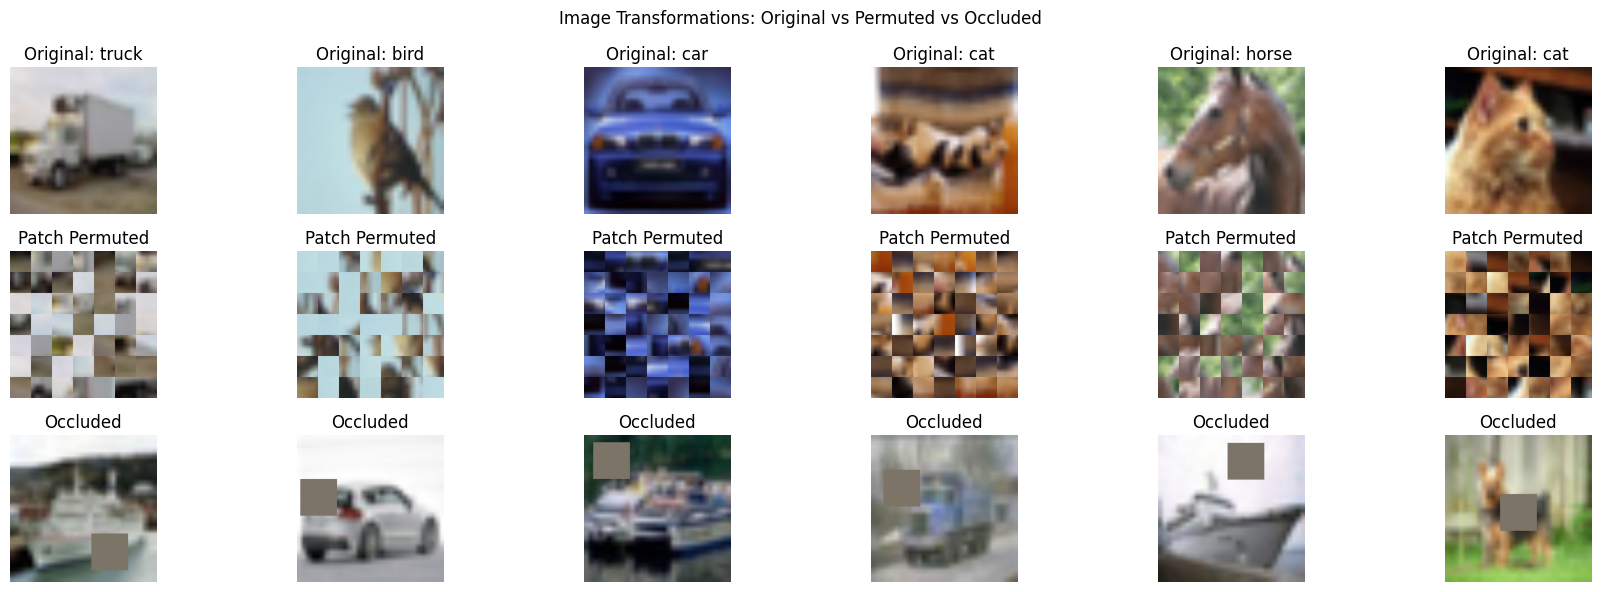

In [ ]:





def create_patch_permuted_dataset(dataset, patch_size=32, n_samples=1000):
    """Create dataset with shuffled patches"""
    class PatchPermutedDataset(Dataset):
        def __init__(self, original_dataset, patch_size, n_samples):
            self.dataset = original_dataset
            self.patch_size = patch_size
            self.indices = random.sample(range(len(original_dataset)), min(n_samples, len(original_dataset)))

        def __len__(self):
            return len(self.indices)

        def shuffle_patches(self, image):
            """Shuffle image patches"""
            c, h, w = image.shape
            n_patches_h = h // self.patch_size
            n_patches_w = w // self.patch_size

            
            patches = []
            for i in range(n_patches_h):
                for j in range(n_patches_w):
                    patch = image[:, i*self.patch_size:(i+1)*self.patch_size,
                                  j*self.patch_size:(j+1)*self.patch_size]
                    patches.append(patch)

            
            random.shuffle(patches)

            
            shuffled = torch.zeros_like(image)
            patch_idx = 0
            for i in range(n_patches_h):
                for j in range(n_patches_w):
                    shuffled[:, i*self.patch_size:(i+1)*self.patch_size,
                             j*self.patch_size:(j+1)*self.patch_size] = patches[patch_idx]
                    patch_idx += 1

            return shuffled

        def __getitem__(self, idx):
            original_idx = self.indices[idx]
            image, label = self.dataset[original_idx]
            shuffled_image = self.shuffle_patches(image)
            return shuffled_image, label   

    return PatchPermutedDataset(dataset, patch_size, n_samples)


def create_occluded_dataset(dataset, occlusion_size=56, n_samples=1000):
    """Create dataset with random occlusions"""
    class OccludedDataset(Dataset):
        def __init__(self, original_dataset, occlusion_size, n_samples):
            self.dataset = original_dataset
            self.occlusion_size = occlusion_size
            self.indices = random.sample(range(len(original_dataset)), min(n_samples, len(original_dataset)))

        def __len__(self):
            return len(self.indices)

        def add_occlusion(self, image):
            """Add random square occlusion"""
            c, h, w = image.shape
            occluded = image.clone()

            max_x = w - self.occlusion_size
            max_y = h - self.occlusion_size

            if max_x > 0 and max_y > 0:
                x = random.randint(0, max_x)
                y = random.randint(0, max_y)
                occluded[:, y:y+self.occlusion_size, x:x+self.occlusion_size] = 0

            return occluded

        def __getitem__(self, idx):
            original_idx = self.indices[idx]
            image, label = self.dataset[original_idx]
            occluded_image = self.add_occlusion(image)
            return occluded_image, label   

    return OccludedDataset(dataset, occlusion_size, n_samples)


print("=== PATCH PERMUTATION/OCCLUSION TEST ===")


permuted_dataset = create_patch_permuted_dataset(test_dataset, patch_size=32, n_samples=500)
permuted_loader = DataLoader(permuted_dataset, batch_size=64, shuffle=False)

print("ResNet-50 Patch Permutation Robustness:")
resnet_permuted_acc = evaluate_model(resnet_model, permuted_loader)
print("ViT Patch Permutation Robustness:")
vit_permuted_acc = evaluate_model(vit_model, permuted_loader)


occluded_dataset = create_occluded_dataset(test_dataset, occlusion_size=56, n_samples=500)
occluded_loader = DataLoader(occluded_dataset, batch_size=64, shuffle=False)

print("ResNet-50 Occlusion Robustness:")
resnet_occluded_acc = evaluate_model(resnet_model, occluded_loader)
print("ViT Occlusion Robustness:")
vit_occluded_acc = evaluate_model(vit_model, occluded_loader)


def visualize_transformations(original_dataset, permuted_dataset, occluded_dataset, n_examples=6):
    """Visualize original, permuted, and occluded images"""
    fig, axes = plt.subplots(3, n_examples, figsize=(18, 6))

    for i in range(n_examples):
        
        orig_idx = permuted_dataset.indices[i]

        
        orig_img, label = original_dataset[orig_idx]
        orig_img_display = torch.clamp(
            orig_img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) +
            torch.tensor([0.485, 0.456, 0.406]).view(3,1,1),
            0, 1
        )
        axes[0, i].imshow(orig_img_display.permute(1, 2, 0))
        axes[0, i].set_title(f'Original: {cifar10_classes[label]}')
        axes[0, i].axis('off')

        
        perm_img, _ = permuted_dataset[i]
        perm_img_display = torch.clamp(
            perm_img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) +
            torch.tensor([0.485, 0.456, 0.406]).view(3,1,1),
            0, 1
        )
        axes[1, i].imshow(perm_img_display.permute(1, 2, 0))
        axes[1, i].set_title('Patch Permuted')
        axes[1, i].axis('off')

        
        occl_img, _ = occluded_dataset[i]
        occl_img_display = torch.clamp(
            occl_img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) +
            torch.tensor([0.485, 0.456, 0.406]).view(3,1,1),
            0, 1
        )
        axes[2, i].imshow(occl_img_display.permute(1, 2, 0))
        axes[2, i].set_title('Occluded')
        axes[2, i].axis('off')

    plt.suptitle('Image Transformations: Original vs Permuted vs Occluded')
    plt.tight_layout()
    plt.show()


visualize_transformations(test_dataset, permuted_dataset, occluded_dataset)

=== FEATURE REPRESENTATION ANALYSIS ===
ResNet-50 features extr
ViT features extr
stylized images features extr
dim reduction step


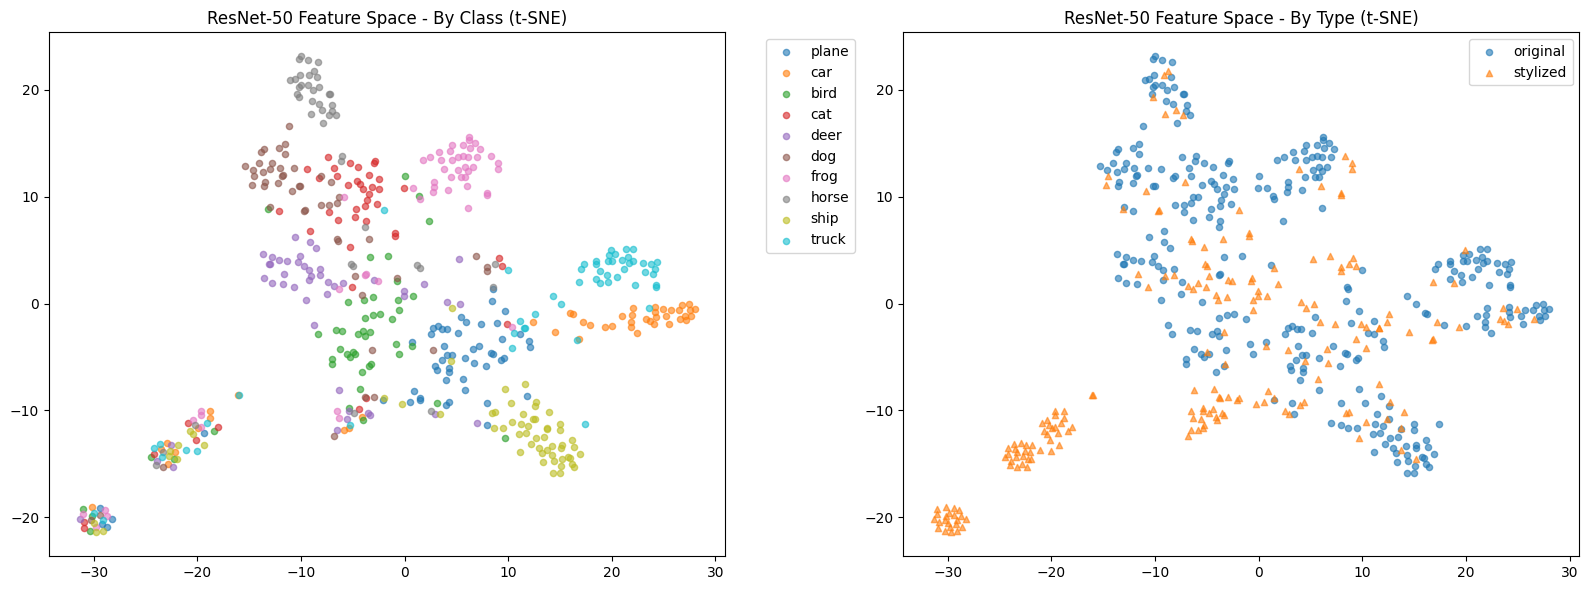

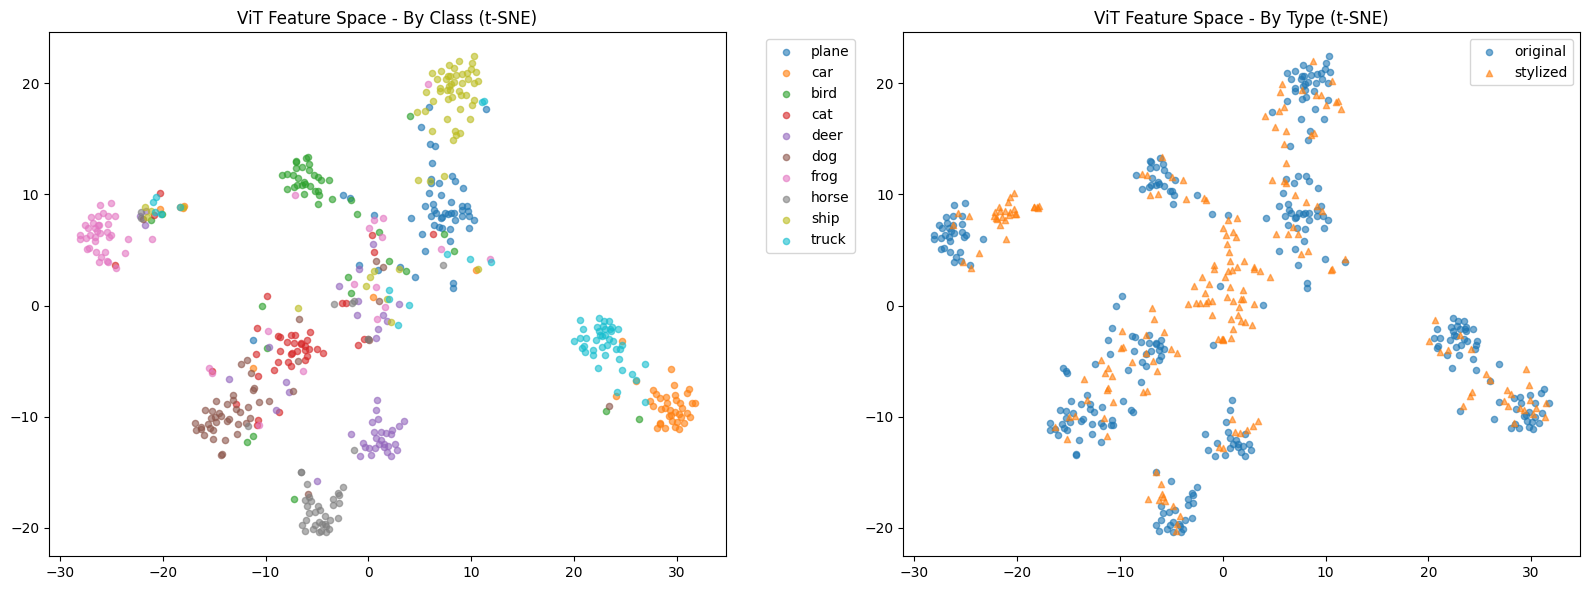

In [ ]:




def extract_features(model, dataloader, n_samples=500):
    """Extract penultimate layer features (ResNet avgpool vs ViT forward_features)."""
    model.eval()
    features = []
    labels = []
    sample_count = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            if sample_count >= n_samples:
                break

            inputs = inputs.to(device)

            
            if isinstance(model, torchvision.models.ResNet):
                
                x = model.conv1(inputs)
                x = model.bn1(x)
                x = model.relu(x)
                x = model.maxpool(x)

                x = model.layer1(x)
                x = model.layer2(x)
                x = model.layer3(x)
                x = model.layer4(x)

                x = model.avgpool(x)         
                x = torch.flatten(x, 1)      

            
            else:
                if hasattr(model, "forward_features"):
                    x = model.forward_features(inputs)   
                    if x.ndim > 2:  
                        x = x.mean(dim=1)  
                else:
                    raise ValueError("Model type not supported for feature extraction")

            features.append(x.cpu().numpy())
            labels.extend(targets.numpy())
            sample_count += len(targets)

    features = np.vstack(features)[:n_samples]
    labels = np.array(labels)[:n_samples]
    return features, labels


print("=== FEATURE REPRESENTATION ANALYSIS ===")


print("ResNet-50 features extr")
resnet_features, resnet_labels = extract_features(resnet_model, test_loader, n_samples=1000)

print("ViT features extr")
vit_features, vit_labels = extract_features(vit_model, test_loader, n_samples=1000)


print("stylized images features extr")
stylized_sample_loader = DataLoader(stylized_dataset, batch_size=64, shuffle=False)


class SimpleStylizedLoader:
    def __init__(self, stylized_loader):
        self.data = []
        for imgs, labels, _ in stylized_loader:
            for img, label in zip(imgs, labels):
                self.data.append((img, label))

    def __iter__(self):
        batch_size = 64
        for i in range(0, len(self.data), batch_size):
            batch = self.data[i:i+batch_size]
            images = torch.stack([item[0] for item in batch])
            labels = torch.tensor([item[1] for item in batch])
            yield images, labels

simple_stylized_loader = SimpleStylizedLoader(stylized_sample_loader)

resnet_stylized_features, resnet_stylized_labels = extract_features(resnet_model, simple_stylized_loader, n_samples=500)
vit_stylized_features, vit_stylized_labels = extract_features(vit_model, simple_stylized_loader, n_samples=500)


print("dim reduction step")


pca_resnet = PCA(n_components=50)
resnet_features_pca = pca_resnet.fit_transform(resnet_features)
resnet_stylized_features_pca = pca_resnet.transform(resnet_stylized_features)


tsne_resnet = TSNE(n_components=2, random_state=42, perplexity=30)
resnet_combined = np.vstack([resnet_features_pca[:300], resnet_stylized_features_pca[:200]])
resnet_combined_labels = np.hstack([resnet_labels[:300], resnet_stylized_labels[:200]])
resnet_combined_types = ['original'] * 300 + ['stylized'] * 200
resnet_tsne = tsne_resnet.fit_transform(resnet_combined)


pca_vit = PCA(n_components=50)
vit_features_pca = pca_vit.fit_transform(vit_features)
vit_stylized_features_pca = pca_vit.transform(vit_stylized_features)


tsne_vit = TSNE(n_components=2, random_state=42, perplexity=30)
vit_combined = np.vstack([vit_features_pca[:300], vit_stylized_features_pca[:200]])
vit_combined_labels = np.hstack([vit_labels[:300], vit_stylized_labels[:200]])
vit_combined_types = ['original'] * 300 + ['stylized'] * 200
vit_tsne = tsne_vit.fit_transform(vit_combined)


def plot_feature_space(embeddings, labels, types, model_name, title_suffix=""):
    """Plot feature space with class and type information"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    for class_idx in range(10):
        mask = labels == class_idx
        ax1.scatter(embeddings[mask, 0], embeddings[mask, 1],
                   c=[colors[class_idx]], label=cifar10_classes[class_idx],
                   alpha=0.6, s=20)
    ax1.set_title(f'{model_name} Feature Space - By Class {title_suffix}')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    
    for type_name in ['original', 'stylized']:
        mask = np.array(types) == type_name
        marker = 'o' if type_name == 'original' else '^'
        ax2.scatter(embeddings[mask, 0], embeddings[mask, 1],
                   label=type_name, alpha=0.6, s=20, marker=marker)
    ax2.set_title(f'{model_name} Feature Space - By Type {title_suffix}')
    ax2.legend()

    plt.tight_layout()
    plt.show()


plot_feature_space(resnet_tsne, resnet_combined_labels, resnet_combined_types, "ResNet-50", "(t-SNE)")
plot_feature_space(vit_tsne, vit_combined_labels, vit_combined_types, "ViT", "(t-SNE)")


In [ ]:


def analyze_feature_representations(features, labels, types, model_name):
    """Compute quantitative metrics for feature representation analysis"""
    from sklearn.metrics import silhouette_score
    from sklearn.neighbors import NearestNeighbors
    from scipy.spatial.distance import pdist, squareform

    print(f"\n=== {model_name} Feature Analysis Metrics ===")

    
    sil_score = silhouette_score(features, labels)
    print(f"Class Silhouette Score: {sil_score:.3f} (higher = better class separation)")

    
    intra_distances = []
    inter_distances = []

    for class_idx in range(10):
        class_mask = labels == class_idx
        class_features = features[class_mask]

        if len(class_features) > 1:
            
            intra_dist = pdist(class_features).mean()
            intra_distances.append(intra_dist)

            
            other_features = features[~class_mask]
            if len(other_features) > 0:
                inter_dist = []
                for feat in class_features:
                    dists = np.linalg.norm(other_features - feat, axis=1)
                    inter_dist.extend(dists)
                inter_distances.extend(inter_dist)

    avg_intra = np.mean(intra_distances)
    avg_inter = np.mean(inter_distances)
    separation_ratio = avg_inter / avg_intra if avg_intra > 0 else 0

    print(f"Average intra-class distance: {avg_intra:.3f}")
    print(f"Average inter-class distance: {avg_inter:.3f}")
    print(f"Separation ratio (inter/intra): {separation_ratio:.3f} (higher = better)")

    
    original_mask = np.array(types) == 'original'
    stylized_mask = np.array(types) == 'stylized'

    if np.any(stylized_mask):
        
        stylized_to_original_distances = []

        for class_idx in range(10):
            stylized_class_mask = stylized_mask & (labels == class_idx)
            original_class_mask = original_mask & (labels == class_idx)

            if np.any(stylized_class_mask) and np.any(original_class_mask):
                stylized_features = features[stylized_class_mask]
                original_features = features[original_class_mask]

                for stylized_feat in stylized_features:
                    distances = np.linalg.norm(original_features - stylized_feat, axis=1)
                    min_distance = distances.min()
                    stylized_to_original_distances.append(min_distance)

        if stylized_to_original_distances:
            avg_stylized_distance = np.mean(stylized_to_original_distances)
            print(f"Avg distance: stylized → original (same class): {avg_stylized_distance:.3f}")
            print(f"  (lower = stylized images stay closer to original class)")

    
    nbrs = NearestNeighbors(n_neighbors=6).fit(features)  
    distances, _ = nbrs.kneighbors(features)
    avg_density = distances[:, 1:].mean()  
    print(f"Average neighborhood density: {avg_density:.3f} (lower = more compact)")

    return {
        'silhouette_score': sil_score,
        'separation_ratio': separation_ratio,
        'avg_stylized_distance': avg_stylized_distance if 'avg_stylized_distance' in locals() else None,
        'avg_density': avg_density
    }


resnet_metrics = analyze_feature_representations(resnet_tsne, resnet_combined_labels,
                                               resnet_combined_types, "ResNet-50")

vit_metrics = analyze_feature_representations(vit_tsne, vit_combined_labels,
                                            vit_combined_types, "ViT")


print(f"\n=== COMPARATIVE SUMMARY ===")
print(f"Class Separation (Silhouette):")
print(f"  ResNet-50: {resnet_metrics['silhouette_score']:.3f}")
print(f"  ViT:       {vit_metrics['silhouette_score']:.3f}")
print(f"  → {'ViT' if vit_metrics['silhouette_score'] > resnet_metrics['silhouette_score'] else 'ResNet'} has better class separation")

print(f"\nSeparation Ratio (inter/intra distance):")
print(f"  ResNet-50: {resnet_metrics['separation_ratio']:.3f}")
print(f"  ViT:       {vit_metrics['separation_ratio']:.3f}")
print(f"  → {'ViT' if vit_metrics['separation_ratio'] > resnet_metrics['separation_ratio'] else 'ResNet'} has better class clustering")

if resnet_metrics['avg_stylized_distance'] and vit_metrics['avg_stylized_distance']:
    print(f"\nStylized Image Coherence (distance to original class):")
    print(f"  ResNet-50: {resnet_metrics['avg_stylized_distance']:.3f}")
    print(f"  ViT:       {vit_metrics['avg_stylized_distance']:.3f}")
    print(f"  → {'ViT' if vit_metrics['avg_stylized_distance'] < resnet_metrics['avg_stylized_distance'] else 'ResNet'} keeps stylized images closer to original class")


=== ResNet-50 Feature Analysis Metrics ===
Class Silhouette Score: 0.049 (higher = better class separation)
Average intra-class distance: 14.195
Average inter-class distance: 22.661
Separation ratio (inter/intra): 1.596 (higher = better)
Avg distance: stylized → original (same class): 12.530
  (lower = stylized images stay closer to original class)
Average neighborhood density: 1.156 (lower = more compact)

=== ViT Feature Analysis Metrics ===
Class Silhouette Score: 0.173 (higher = better class separation)
Average intra-class distance: 10.435
Average inter-class distance: 24.595
Separation ratio (inter/intra): 2.357 (higher = better)
Avg distance: stylized → original (same class): 6.384
  (lower = stylized images stay closer to original class)
Average neighborhood density: 0.954 (lower = more compact)

=== COMPARATIVE SUMMARY ===
Class Separation (Silhouette):
  ResNet-50: 0.049
  ViT:       0.173
  → ViT has better class separation

Separation Ratio (inter/intra distance):
  ResNet-

OLD ONE - Correct

In [ ]:
print("=== DOMAIN GENERALIZATION TEST (PACS SIMULATION) ===")


domain_datasets = create_domain_shift_datasets(test_dataset, n_samples_per_domain=300)


train_domains = []
for domain in ['photo', 'art', 'cartoon']:
    for img, label in domain_datasets[domain]:
        train_domains.append((img, label))

print(f"Training on {len(train_domains)} samples from Photo+Art+Cartoon domains")

class CombinedDomainDataset(Dataset):
    def __init__(self, domain_data):
        self.data = domain_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


combined_train_dataset = CombinedDomainDataset(train_domains)
combined_train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)
sketch_test_loader = DataLoader(domain_datasets['sketch'], batch_size=64, shuffle=False)


def fine_tune_on_domains(model, train_loader, model_name, epochs=5):
    """Fine-tune model on combined domains"""
    print(f"\nFine-tuning {model_name} on Photo+Art+Cartoon domains...")

    model.train()
    criterion = nn.CrossEntropyLoss()

    if 'resnet' in model_name.lower():
        optimizer = optim.Adam(model.parameters(), lr=0.001)  
    else:  
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        epoch_acc = 100. * correct / total
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Acc: {epoch_acc:.2f}%, Loss: {epoch_loss:.4f}")


print("=== BASELINE PERFORMANCE (before domain fine-tuning) ===")
resnet_original_sketch = evaluate_model(resnet_model, sketch_test_loader, verbose=False)
vit_original_sketch = evaluate_model(vit_model, sketch_test_loader, verbose=False)

print(f"ResNet-50 on Sketch (before domain training): {resnet_original_sketch:.2f}%")
print(f"ViT on Sketch (before domain training): {vit_original_sketch:.2f}%")


fine_tune_on_domains(resnet_model, combined_train_loader, "ResNet-50", epochs=2)
fine_tune_on_domains(vit_model, combined_train_loader, "ViT", epochs=2)


print("\n=== DOMAIN GENERALIZATION RESULTS ===")
print("Testing on held-out Sketch domain...")

resnet_sketch_acc = evaluate_model(resnet_model, sketch_test_loader, verbose=False)
vit_sketch_acc = evaluate_model(vit_model, sketch_test_loader, verbose=False)

print(f"\nAfter training on Photo+Art+Cartoon:")
print(f"ResNet-50 on Sketch: {resnet_sketch_acc:.2f}%")
print(f"ViT on Sketch:       {vit_sketch_acc:.2f}%")


resnet_improvement = resnet_sketch_acc - resnet_original_sketch
vit_improvement = vit_sketch_acc - vit_original_sketch

print(f"\nImprovement from domain training:")
print(f"ResNet-50: {resnet_improvement:+.2f}%")
print(f"ViT:       {vit_improvement:+.2f}%")

print(f"\nDomain Generalization Analysis:")
if vit_sketch_acc > resnet_sketch_acc:
    print(f"✓ ViT generalizes better to Sketch domain (+{vit_sketch_acc - resnet_sketch_acc:.2f}%)")
else:
    print(f"✗ ResNet generalizes better to Sketch domain (+{resnet_sketch_acc - vit_sketch_acc:.2f}%)")


print(f"\nPerformance on training domains (Photo+Art+Cartoon):")
train_domain_acc = evaluate_model(resnet_model, combined_train_loader, verbose=False)
print(f"ResNet-50: {train_domain_acc:.2f}%")
train_domain_acc = evaluate_model(vit_model, combined_train_loader, verbose=False)
print(f"ViT:       {train_domain_acc:.2f}%")

=== DOMAIN GENERALIZATION TEST (PACS SIMULATION) ===
Training on 900 samples from Photo+Art+Cartoon domains
=== BASELINE PERFORMANCE (before domain fine-tuning) ===
ResNet-50 on Sketch (before domain training): 15.33%
ViT on Sketch (before domain training): 10.67%

Fine-tuning ResNet-50 on Photo+Art+Cartoon domains...


Epoch 1/2: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch 1: Acc: 83.89%, Loss: 0.5883


Epoch 2/2: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


Epoch 2: Acc: 94.89%, Loss: 0.2228

Fine-tuning ViT on Photo+Art+Cartoon domains...


Epoch 1/2: 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


Epoch 1: Acc: 86.89%, Loss: 0.3834


Epoch 2/2: 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


Epoch 2: Acc: 98.56%, Loss: 0.0719

=== DOMAIN GENERALIZATION RESULTS ===
Testing on held-out Sketch domain...

After training on Photo+Art+Cartoon:
ResNet-50 on Sketch: 14.33%
ViT on Sketch:       10.33%

Improvement from domain training:
ResNet-50: -1.00%
ViT:       -0.33%

Domain Generalization Analysis:
✗ ResNet generalizes better to Sketch domain (+4.00%)

Performance on training domains (Photo+Art+Cartoon):
ResNet-50: 97.78%
ViT:       100.00%


=== DOMAIN GENERALIZATION TEST (PACS SIMULATION) ===
Evaluating domain generalization...
=== BASELINE PERFORMANCE ===
ResNet-50 baseline (original CIFAR-10):
Accuracy: 84.90%
ViT baseline (original CIFAR-10):
Accuracy: 92.35%

=== DOMAIN-SPECIFIC PERFORMANCE ===

PHOTO Domain:
ResNet-50: 84.50%
ViT:       89.50%

ART Domain:
ResNet-50: 87.50%
ViT:       91.00%

CARTOON Domain:
ResNet-50: 74.50%
ViT:       81.00%

SKETCH Domain:
ResNet-50: 73.50%
ViT:       77.50%

=== DOMAIN GENERALIZATION ANALYSIS ===
Average accuracy drop:
  ResNet-50: 4.90% (±6.10)
  ViT:       7.60% (±5.66)

Worst-performing domain:
  ResNet-50: sketch (73.50%)
  ViT:       sketch (77.50%)

Sketch domain analysis (critical for shape vs texture bias):
  ResNet-50: 73.50% (drop: 11.40%)
  ViT:       77.50% (drop: 14.85%)
  ViT advantage on sketch: 4.00% (ViT better)

Domain consistency (lower std = more consistent):
  ResNet-50 std: 6.10%
  ViT std:       5.66%

Relative performance maintenance:
  ResNet-50: 0.942 (9

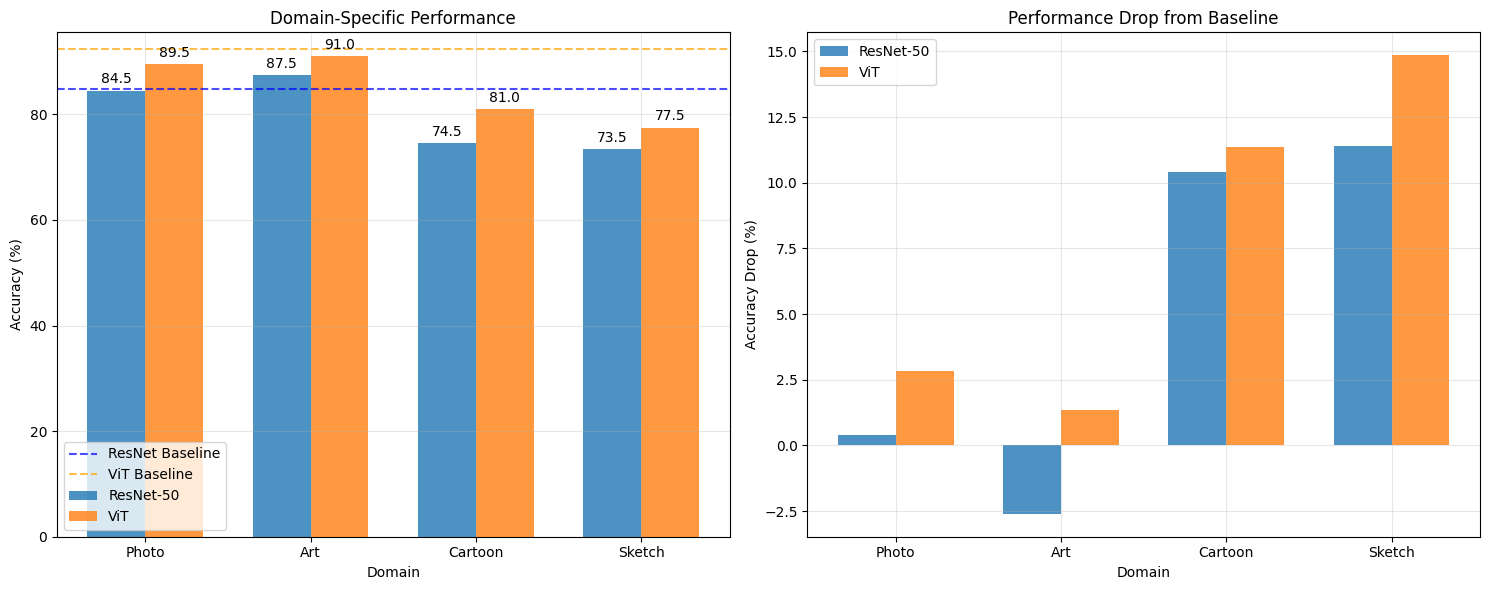

In [ ]:


def create_domain_shift_datasets(dataset, n_samples_per_domain=200):
    """Create datasets simulating different domains (Photo, Art, Cartoon, Sketch)"""

    class DomainDataset(Dataset):
        def __init__(self, original_dataset, domain_type, n_samples):
            self.dataset = original_dataset
            self.domain_type = domain_type
            self.indices = random.sample(range(len(original_dataset)), min(n_samples, len(original_dataset)))

        def __len__(self):
            return len(self.indices)

        def apply_domain_transform(self, image):
            """Apply domain-specific transforms"""
            
            image_denorm = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + \
                          torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            image_denorm = torch.clamp(image_denorm, 0, 1)
            img_np = image_denorm.permute(1, 2, 0).numpy()

            if self.domain_type == 'photo':
                
                transformed = img_np
            elif self.domain_type == 'art':
                
                transformed = np.power(img_np, 0.7)  
            elif self.domain_type == 'cartoon':
                
                transformed = np.round(img_np * 4) / 4
            elif self.domain_type == 'sketch':
                
                gray = cv2.cvtColor((img_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

                
                edges = cv2.Canny(gray, 30, 100)

                
                edges = edges.astype(np.float32) / 255.0
                gray_norm = gray.astype(np.float32) / 255.0

                
                sketch = 0.7 * gray_norm + 0.3 * edges

                
                sketch_rgb = np.stack([sketch] * 3, axis=-1)
                transformed = np.clip(sketch_rgb, 0, 1)
            else:
                transformed = img_np

            
            transformed_tensor = torch.from_numpy(transformed).permute(2, 0, 1).float()
            transformed_tensor = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(transformed_tensor)

            return transformed_tensor

        def __getitem__(self, idx):
            original_idx = self.indices[idx]
            image, label = self.dataset[original_idx]
            transformed_image = self.apply_domain_transform(image)
            return transformed_image, label

    domains = {}
    for domain in ['photo', 'art', 'cartoon', 'sketch']:
        domains[domain] = DomainDataset(dataset, domain, n_samples_per_domain)

    return domains

print("=== DOMAIN GENERALIZATION TEST (PACS SIMULATION) ===")


domain_datasets = create_domain_shift_datasets(test_dataset, n_samples_per_domain=200)


train_domains = []
for domain in ['photo', 'art', 'cartoon']:
    train_domains.extend([(img, label) for img, label in domain_datasets[domain]])

class CombinedDomainDataset(Dataset):
    def __init__(self, domain_data):
        self.data = domain_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

combined_train_dataset = CombinedDomainDataset(train_domains)
combined_train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)


sketch_loader = DataLoader(domain_datasets['sketch'], batch_size=64, shuffle=False)

print("Evaluating domain generalization...")


print("=== BASELINE PERFORMANCE ===")
print("ResNet-50 baseline (original CIFAR-10):")
resnet_baseline = evaluate_model(resnet_model, test_loader)

print("ViT baseline (original CIFAR-10):")
vit_baseline = evaluate_model(vit_model, test_loader)


print("\n=== DOMAIN-SPECIFIC PERFORMANCE ===")
domain_results = {}

for domain_name in ['photo', 'art', 'cartoon', 'sketch']:
    domain_loader = DataLoader(domain_datasets[domain_name], batch_size=64, shuffle=False)

    print(f"\n{domain_name.upper()} Domain:")
    resnet_acc = evaluate_model(resnet_model, domain_loader, verbose=False)
    vit_acc = evaluate_model(vit_model, domain_loader, verbose=False)

    print(f"ResNet-50: {resnet_acc:.2f}%")
    print(f"ViT:       {vit_acc:.2f}%")

    domain_results[domain_name] = {
        'resnet': resnet_acc,
        'vit': vit_acc,
        'resnet_drop': resnet_baseline - resnet_acc,
        'vit_drop': vit_baseline - vit_acc
    }


print("\n=== DOMAIN GENERALIZATION ANALYSIS ===")

def analyze_domain_generalization(domain_results, baseline_resnet, baseline_vit):
    """Analyze domain generalization with additional metrics"""

    
    resnet_drops = [domain_results[d]['resnet_drop'] for d in domain_results]
    vit_drops = [domain_results[d]['vit_drop'] for d in domain_results]

    print(f"Average accuracy drop:")
    print(f"  ResNet-50: {np.mean(resnet_drops):.2f}% (±{np.std(resnet_drops):.2f})")
    print(f"  ViT:       {np.mean(vit_drops):.2f}% (±{np.std(vit_drops):.2f})")

    
    worst_resnet_domain = min(domain_results, key=lambda x: domain_results[x]['resnet'])
    worst_vit_domain = min(domain_results, key=lambda x: domain_results[x]['vit'])

    print(f"\nWorst-performing domain:")
    print(f"  ResNet-50: {worst_resnet_domain} ({domain_results[worst_resnet_domain]['resnet']:.2f}%)")
    print(f"  ViT:       {worst_vit_domain} ({domain_results[worst_vit_domain]['vit']:.2f}%)")

    
    sketch_resnet = domain_results['sketch']['resnet']
    sketch_vit = domain_results['sketch']['vit']
    sketch_diff = sketch_vit - sketch_resnet

    print(f"\nSketch domain analysis (critical for shape vs texture bias):")
    print(f"  ResNet-50: {sketch_resnet:.2f}% (drop: {domain_results['sketch']['resnet_drop']:.2f}%)")
    print(f"  ViT:       {sketch_vit:.2f}% (drop: {domain_results['sketch']['vit_drop']:.2f}%)")
    print(f"  ViT advantage on sketch: {sketch_diff:.2f}% {'(ViT better)' if sketch_diff > 0 else '(ResNet better)'}")

    
    resnet_accs = [domain_results[d]['resnet'] for d in domain_results]
    vit_accs = [domain_results[d]['vit'] for d in domain_results]

    print(f"\nDomain consistency (lower std = more consistent):")
    print(f"  ResNet-50 std: {np.std(resnet_accs):.2f}%")
    print(f"  ViT std:       {np.std(vit_accs):.2f}%")

    
    resnet_relative = np.mean([domain_results[d]['resnet']/baseline_resnet for d in domain_results])
    vit_relative = np.mean([domain_results[d]['vit']/baseline_vit for d in domain_results])

    print(f"\nRelative performance maintenance:")
    print(f"  ResNet-50: {resnet_relative:.3f} ({resnet_relative*100:.1f}% of baseline)")
    print(f"  ViT:       {vit_relative:.3f} ({vit_relative*100:.1f}% of baseline)")

    return {
        'sketch_advantage': sketch_diff,
        'avg_drop_resnet': np.mean(resnet_drops),
        'avg_drop_vit': np.mean(vit_drops),
        'consistency_resnet': np.std(resnet_accs),
        'consistency_vit': np.std(vit_accs)
    }


metrics = analyze_domain_generalization(domain_results, resnet_baseline, vit_baseline)


def plot_domain_performance(domain_results, baseline_resnet, baseline_vit):
    """Plot domain generalization results"""
    domains = list(domain_results.keys())
    resnet_accs = [domain_results[d]['resnet'] for d in domains]
    vit_accs = [domain_results[d]['vit'] for d in domains]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    
    x = np.arange(len(domains))
    width = 0.35

    bars1 = ax1.bar(x - width/2, resnet_accs, width, label='ResNet-50', alpha=0.8)
    bars2 = ax1.bar(x + width/2, vit_accs, width, label='ViT', alpha=0.8)

    ax1.axhline(y=resnet_baseline, color='blue', linestyle='--', alpha=0.7, label='ResNet Baseline')
    ax1.axhline(y=vit_baseline, color='orange', linestyle='--', alpha=0.7, label='ViT Baseline')

    ax1.set_xlabel('Domain')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Domain-Specific Performance')
    ax1.set_xticks(x)
    ax1.set_xticklabels([d.capitalize() for d in domains])
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    for bar in bars2:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    
    resnet_drops = [domain_results[d]['resnet_drop'] for d in domains]
    vit_drops = [domain_results[d]['vit_drop'] for d in domains]

    bars3 = ax2.bar(x - width/2, resnet_drops, width, label='ResNet-50', alpha=0.8)
    bars4 = ax2.bar(x + width/2, vit_drops, width, label='ViT', alpha=0.8)

    ax2.set_xlabel('Domain')
    ax2.set_ylabel('Accuracy Drop (%)')
    ax2.set_title('Performance Drop from Baseline')
    ax2.set_xticks(x)
    ax2.set_xticklabels([d.capitalize() for d in domains])
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_domain_performance(domain_results, resnet_baseline, vit_baseline)


In [ ]:
import pandas as pd
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import io
from sklearn.model_selection import train_test_split


dataset = load_dataset("flwrlabs/pacs")
df = dataset['train'].to_pandas()


df_train, df_test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['label'])


print(f"Training samples: {len(df_train)}")
print(f"Testing samples: {len(df_test)}")
print("Training DataFrame head:")
print(df_train.head())
print("Testing DataFrame head:")
print(df_test.head())


class PACSDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)  
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = row['image']
        label = row['label']

        
        if isinstance(image, bytes):
            image = Image.open(io.BytesIO(image)).convert('RGB')
        elif isinstance(image, dict):
            image = Image.open(io.BytesIO(image['bytes'])).convert('RGB')
        else:
            image = image.convert('RGB')  

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


train_dataset = PACSDataset(df_train, transform=transform)
test_dataset = PACSDataset(df_test, transform=transform)


test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


images, labels = next(iter(test_loader))
print(f"Batch shape: {images.shape}, Labels: {labels.shape}")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

Training samples: 8991
Testing samples: 1000
Training DataFrame head:
                                                  image        domain  label
8860  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...        sketch      3
7731  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...        sketch      2
5741  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...         photo      6
496   {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  art_painting      1
4451  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...         photo      0
Testing DataFrame head:
                                                  image        domain  label
1834  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  art_painting      6
3518  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...       cartoon      4
8449  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...        sketch      3
5935  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...         photo      6
3898  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    

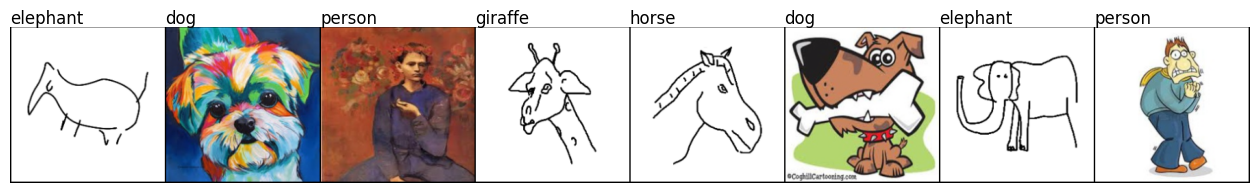

In [ ]:
import matplotlib.pyplot as plt
import torchvision


id2label = dataset["train"].features["label"].int2str

def visualize_pacs_batch(dataloader, n_images=8):
    images, labels = next(iter(dataloader))

    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    images_unnorm = images * std + mean
    images_unnorm = torch.clamp(images_unnorm, 0, 1)

    
    grid_img = torchvision.utils.make_grid(images_unnorm[:n_images], nrow=n_images, padding=2)
    plt.figure(figsize=(16, 4))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    
    label_names = [id2label(int(l)) for l in labels[:n_images]]
    for i, name in enumerate(label_names):
        plt.text(i * (224 + 2), -5, name, color='black', fontsize=12)

    plt.show()


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
visualize_pacs_batch(train_loader, n_images=8)



https://huggingface.co/datasets/flwrlabs/pacs

TASK 1.9: Correct

---

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from datasets import load_dataset
import io
from PIL import Image
import random
import numpy as np




dataset = load_dataset("flwrlabs/pacs")
df = dataset['train'].to_pandas()


domains = df['domain'].unique().tolist()
print("Available PACS domains:", domains)


domain_dfs = {d: df[df['domain'] == d].reset_index(drop=True) for d in domains}




class PACSDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image, label = row['image'], row['label']

        
        if isinstance(image, bytes):
            image = Image.open(io.BytesIO(image)).convert('RGB')
        elif isinstance(image, dict) and 'bytes' in image:
            image = Image.open(io.BytesIO(image['bytes'])).convert('RGB')
        elif not isinstance(image, Image.Image):
            raise ValueError("Image format not recognized")

        if self.transform:
            image = self.transform(image)

        return image, label




transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])




device = "cuda" if torch.cuda.is_available() else "cpu"

def train_model(model, loader, epochs=3, lr=1e-4):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss={total_loss/len(loader):.4f}")

def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return 100.0 * correct / total

import timm

def sketch_domain_generalization(batch_size=64, epochs=3):
    held_out = "sketch"
    print(f"\n=== Training on all except [{held_out}] and testing on [{held_out}] ===")

    
    train_datasets = []
    for d in domains:
        if d != held_out:
            train_datasets.append(PACSDataset(domain_dfs[d], transform=transform))
    train_dataset = ConcatDataset(train_datasets)

    
    test_dataset = PACSDataset(domain_dfs[held_out], transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    
    resnet = timm.create_model("resnet50", pretrained=False, num_classes=10).to(device)
    resnet.load_state_dict(torch.load("/content/resnet50_task1.pth", map_location=device))

    vit = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=10).to(device)
    vit.load_state_dict(torch.load("/content/vit_task1.pth", map_location=device))

    
    print("Fine-tuning ResNet...")
    train_model(resnet, train_loader, epochs=epochs)
    resnet_acc = evaluate_model(resnet, test_loader)
    print(f"ResNet Accuracy on {held_out}: {resnet_acc:.2f}%")

    
    print("Fine-tuning ViT...")
    train_model(vit, train_loader, epochs=epochs)
    vit_acc = evaluate_model(vit, test_loader)
    print(f"ViT Accuracy on {held_out}: {vit_acc:.2f}%")

    return {
        "resnet": resnet_acc,
        "vit": vit_acc
    }






results = sketch_domain_generalization(batch_size=64, epochs=3)
print("\nFinal Results (Sketch held-out):", results)


Available PACS domains: ['art_painting', 'cartoon', 'photo', 'sketch']

=== Training on all except [sketch] and testing on [sketch] ===
Fine-tuning ResNet...
Epoch 1/3, Loss=2.9935
Epoch 2/3, Loss=1.1623
Epoch 3/3, Loss=0.8207
ResNet Accuracy on sketch: 54.11%
Fine-tuning ViT...
Epoch 1/3, Loss=1.4943
Epoch 2/3, Loss=0.7072
Epoch 3/3, Loss=0.3106
ViT Accuracy on sketch: 37.57%

Final Results (Sketch held-out): {'resnet': 54.11046067701705, 'vit': 37.566810893357086}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from datasets import load_dataset
import io
from PIL import Image
import random
import numpy as np




dataset = load_dataset("flwrlabs/pacs")
df = dataset['train'].to_pandas()


domains = df['domain'].unique().tolist()
print("Available PACS domains:", domains)


domain_dfs = {d: df[df['domain'] == d].reset_index(drop=True) for d in domains}




class PACSDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image, label = row['image'], row['label']

        
        if isinstance(image, bytes):
            image = Image.open(io.BytesIO(image)).convert('RGB')
        elif isinstance(image, dict) and 'bytes' in image:
            image = Image.open(io.BytesIO(image['bytes'])).convert('RGB')
        elif not isinstance(image, Image.Image):
            raise ValueError("Image format not recognized")

        if self.transform:
            image = self.transform(image)

        return image, label




transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])




device = "cuda" if torch.cuda.is_available() else "cpu"

def train_model(model, loader, epochs=3, lr=1e-4):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss={total_loss/len(loader):.4f}")

def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return 100.0 * correct / total

import timm

def sketch_domain_generalization(batch_size=64, epochs=3):
    held_out = "art_painting"
    print(f"\n=== Training on all except [{held_out}] and testing on [{held_out}] ===")

    
    train_datasets = []
    for d in domains:
        if d != held_out:
            train_datasets.append(PACSDataset(domain_dfs[d], transform=transform))
    train_dataset = ConcatDataset(train_datasets)

    
    test_dataset = PACSDataset(domain_dfs[held_out], transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    
    resnet = timm.create_model("resnet50", pretrained=False, num_classes=10).to(device)
    resnet.load_state_dict(torch.load("/content/resnet50_task1.pth", map_location=device))

    vit = timm.create_model("vit_small_patch16_224", pretrained=False, num_classes=10).to(device)
    vit.load_state_dict(torch.load("/content/vit_task1.pth", map_location=device))

    
    print("Fine-tuning ResNet...")
    train_model(resnet, train_loader, epochs=epochs)
    resnet_acc = evaluate_model(resnet, test_loader)
    print(f"ResNet Accuracy on {held_out}: {resnet_acc:.2f}%")

    
    print("Fine-tuning ViT...")
    train_model(vit, train_loader, epochs=epochs)
    vit_acc = evaluate_model(vit, test_loader)
    print(f"ViT Accuracy on {held_out}: {vit_acc:.2f}%")

    return {
        "resnet": resnet_acc,
        "vit": vit_acc
    }












results = sketch_domain_generalization(batch_size=64, epochs=3)
print("\nFinal Results (Sketch held-out):", results)


Available PACS domains: ['art_painting', 'cartoon', 'photo', 'sketch']

=== Training on all except [art_painting] and testing on [art_painting] ===
Fine-tuning ResNet...
Epoch 1/3, Loss=2.1840
Epoch 2/3, Loss=0.8469
Epoch 3/3, Loss=0.5846
ResNet Accuracy on art_painting: 41.70%
Fine-tuning ViT...
Epoch 1/3, Loss=1.2928
Epoch 2/3, Loss=0.6138
Epoch 3/3, Loss=0.3551
ViT Accuracy on art_painting: 41.41%

Final Results (Sketch held-out): {'resnet': 41.69921875, 'vit': 41.40625}
